### **Import Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### **Define the Dataset**

In [2]:
class FunctionDataset(Dataset):
  """Simple class to create a dataset with features and labels."""
  def __init__(self, num_samples=1000, noise=0.1):
    """
    Parameters
    ----------
    num_samples (int): Number of samples to generate.
    noise (float or int): Noise coefficients to add to the labels
    """
    self.x = torch.linspace(-50, 50, num_samples*2).view(-1, 2)
    # Calculate y values from f(x, y) = 2x + 3y with some noise
    self.y = (2*self.x[:, 0] + 3*self.x[:, 1] + noise*torch.randn(num_samples)).view(-1, 1)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [3]:
# Create dataset instance
dataset = FunctionDataset(num_samples=1000)

print(f"Dataset samples: {len(dataset)}, Features: {len(dataset.x.shape)}, Label: {len(dataset.y.shape)}\n")
print(f"First 5 input features: \n{dataset.x[:5]}\n")
print(f"First 5 output labels: \n{dataset.y[:5]}")

Dataset samples: 1000, Features: 2, Label: 2

First 5 input features: 
tensor([[-50.0000, -49.9500],
        [-49.8999, -49.8499],
        [-49.7999, -49.7499],
        [-49.6998, -49.6498],
        [-49.5998, -49.5498]])

First 5 output labels: 
tensor([[-249.8793],
        [-249.4605],
        [-248.7963],
        [-248.4559],
        [-247.9753]])


### **Split the Dataset**

In [4]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into train, validation and test sets
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Create train, validation and test loader for batch processing
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

print(f"Train set size: {len(train_set)}\nValidation set size: {len(val_set)}\nTest set size: {len(test_set)}")

Train set size: 800
Validation set size: 100
Test set size: 100


### **Define the Neural Network Model**

In [5]:
class SimpleNN(nn.Module):
  """Simple class to create a neural network."""
  def __init__(self):
    """Define model with one hidden layer and ReLu activation function"""
    super().__init__()
    self.fc = nn.Sequential(
        nn.Linear(2, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )

  def forward(self, x):
    return self.fc(x)

# Create model instance
model = SimpleNN()
print(model)

SimpleNN(
  (fc): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


### **Define Loss function and Optimizer**

In [6]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### **Train and Validate the Model**

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0

    for X, y in train_loader:
      optimizer.zero_grad()
      predictions = model(X)
      loss = criterion(predictions, y)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0

    with torch.no_grad():
      for X, y in val_loader:
        predictions = model(X)
        loss = criterion(predictions, y)
        val_loss += loss.item()

    # Add average losses to the list
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    if (epoch+1) % 5 == 0:
      print(f"Epoch {(epoch+1)}/{epochs}, Train loss: {train_losses[epoch]:5f}, Validation loss: {val_losses[epoch]:.5f}")

  return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer)

Epoch 5/50, Train loss: 18406.572461, Validation loss: 23488.94775
Epoch 10/50, Train loss: 14893.220391, Validation loss: 18809.09961
Epoch 15/50, Train loss: 10548.989395, Validation loss: 13136.56226
Epoch 20/50, Train loss: 6064.707422, Validation loss: 7348.89404
Epoch 25/50, Train loss: 2579.582471, Validation loss: 3012.05353
Epoch 30/50, Train loss: 740.992501, Validation loss: 835.38297
Epoch 35/50, Train loss: 137.254339, Validation loss: 148.82255
Epoch 40/50, Train loss: 16.851736, Validation loss: 17.82884
Epoch 45/50, Train loss: 1.686210, Validation loss: 1.78749
Epoch 50/50, Train loss: 0.372166, Validation loss: 0.33055


### **Visualize Train and Validation Loss**

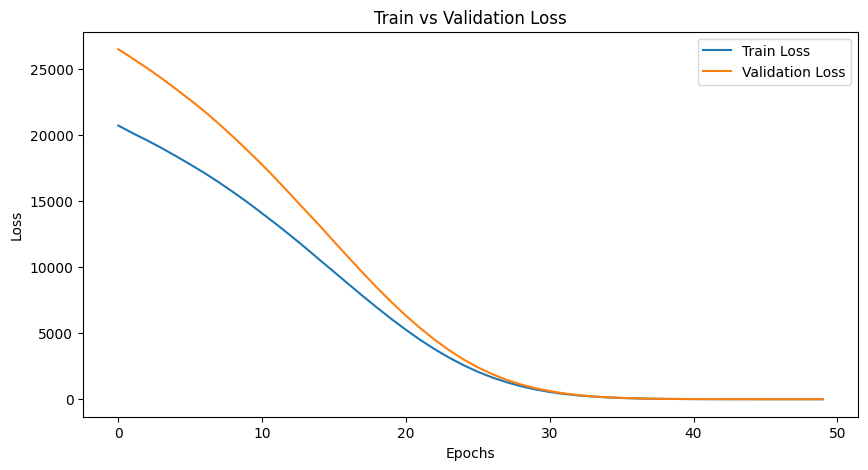

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Train vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### **Test the Model**

In [9]:
model.eval()
all_targets = []
all_predictions = []

with torch.no_grad():
  test_loss = 0
  for X, y in test_loader:
    predictions = model(X)
    loss = criterion(predictions, y)
    test_loss += loss.item()
    all_targets.append(y.squeeze())
    all_predictions.append(predictions.squeeze())

# Average test loss
print(f"Test Loss: {test_loss / len(test_loader):.5f}")

Test Loss: 0.31832


### **Visualize Train and Validation Loss**

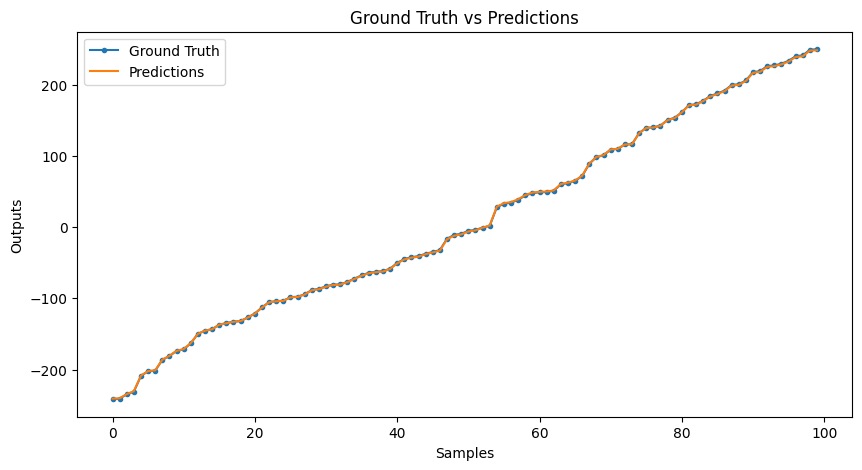

In [10]:
# Prepare targets and predictions for plotting
all_targets = torch.cat(all_targets).numpy()
all_predictions = torch.cat(all_predictions).numpy()

# Sort targets for better visualization
indices = np.argsort(all_targets)
all_targets = all_targets[indices]
all_predictions = all_predictions[indices]

# Plot the predictions and targets
plt.figure(figsize=(10, 5))
plt.plot(all_targets, label="Ground Truth", marker=".")
plt.plot(all_predictions, label="Predictions")
plt.title("Ground Truth vs Predictions")
plt.xlabel("Samples")
plt.ylabel("Outputs")
plt.legend()
plt.show()